In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_color_codes()

# Beliefs

Question: 
> You toss a coin 9 times and you get 6 heads. What is the bias of the coin?

How do you approach this problem computationally?

### Sampling from grid-approximate posterior

Given you get 6 heads out of 9 tosses, and a uniform prior, approximate a posterior distribution by sampling 10,000 samples from the posterior.

In [2]:
p_grid = np.linspace(0, 1, 100)
prior = np.repeat(1, 100)
likelihood = stats.binom.pmf(k=6, n=9, p=p_grid)
posterior = (likelihood * prior)/(likelihood * prior).sum()

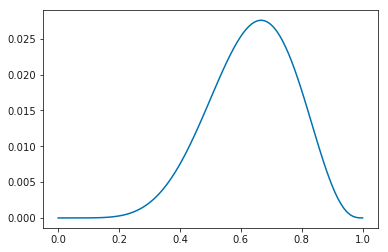

In [3]:
plt.plot(p_grid, posterior)

In [4]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

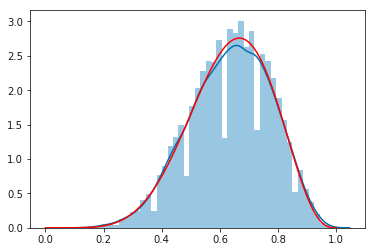

In [5]:
sns.distplot(samples)
plt.plot(p_grid, posterior*1e2, color='red')

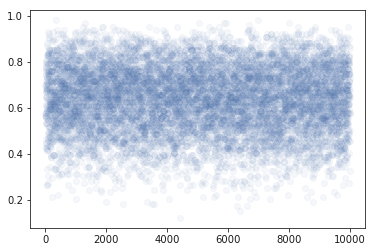

In [6]:
plt.plot(samples, 'bo', alpha=0.05)

Answer the following questions about this posterior distribution

- What is the probability that the coin bias is < 50%
- What is the probability that the coin bias is between 0.5 and 0.75
- What is the 80th percentile of the coin bias?
- What are the 10th and 90th percentiles of the posterior?

In [7]:
# What is the probability that the coin bias is < 50%
p_lt_5 = np.sum(samples < 0.5)/1E4

# What is the probability that the coin bias is between 0.5 and 0.75
p_bw_050_075 = np.sum((samples > 0.5) & (samples < 0.75))/1E4

# What is the 80th percentile of the coin bias?
p_pct_80 = np.percentile(samples, 80)

# 10th and 90th percentiles of posterior
pct_10_and_90 = np.percentile(samples, (10, 90))
p_lt_5, p_bw_050_075, p_pct_80, pct_10_and_90

# Print results
print('P(bias < 0.5) = %s' % p_lt_5)
print('P(0.5 <= bias <= 0.75) = %s' % p_bw_050_075)
print('π(x) means xth percentile')
print('π(0.8) = %s' % p_pct_80)
print('π(0.1) = %s, π(0.9) = %s' % (pct_10_and_90[0], pct_10_and_90[1]))

P(bias < 0.5) = 0.1741
P(0.5 <= bias <= 0.75) = 0.6035
π(x) means xth percentile
π(0.8) = 0.757575757576
π(0.1) = 0.444444444444, π(0.9) = 0.818181818182


### Point estimates and HPDI

Now rerun the experiment with 3 heads out of 3 tosses
- What are the first and third quartiles of the posterior?
- What is the **Highest Posterior Density Interval (HPDI)** of the posterior? **PyMC3 has a HPD function**
- What is the mode of the posterior?
- What are the mean and median of the posterior?

In [8]:
p_grid = np.linspace(0, 1, 100)
prior = np.repeat(1, 100)
likelihood = stats.binom.pmf(k=3, n=3, p=p_grid)
posterior = (likelihood * prior)/(likelihood * prior).sum()

samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

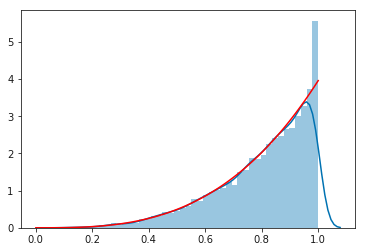

In [9]:
sns.distplot(samples)
plt.plot(p_grid, posterior*1e2, color='red')

In [10]:
pct_25_75 = np.percentile(samples, [25, 75])
hpd = pm.hpd(samples, 0.5)
mean = samples.mean()
median = np.median(samples)
mode = stats.mode(samples)

pct_25_75, hpd, mean, median, mode

(array([ 0.71717172,  0.93939394]),
 array([ 0.84848485,  1.        ]),
 0.80483939393939397,
 0.84848484848484851,
 ModeResult(mode=array([ 0.95959596]), count=array([388])))

### Point estimate using `loss function`

- Let's assume the _true_ value of bias of the coin is `p`.
- And let's assume the penalty for guessing anything other than `p` is proportional to how far off we are, i.e. the loss is proportional to $abs(d-p)$
- Our _belief_ that the true value is `d` is posterior probability at `d`.
- The _expected loss_ therefore is $\sum_x{posterior*abs(d-x)}$ where `d` varies from 0 to 1.
- Our job then is to find a value of `d` that minimizes this loss.

In [11]:
d_grid = np.linspace(0, 1, 1000)

In [12]:
results = np.zeros(1000)
# FIXME: Vectorize this
for i, v in enumerate(d_grid):
    results[i] = (posterior * abs(v - p_grid )).sum() 

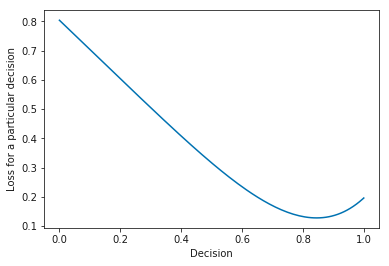

In [13]:
plt.plot(d_grid, results)
plt.xlabel('Decision')
plt.ylabel('Loss for a particular decision')

In [14]:
d_grid[np.argmin(results)]

0.84784784784784784

Notice that the optimal decision, i.e. the point value of probability that minimizes expected loss in this case is 0.8478.

We can choose many other loss functions. The definition of loss as `abs(d-p)` was arbitrary

This can also be solved as an optimization problem instead of graphically. We can minimize `posterior * abs(d - p_grid)).sum()` subject to `d`. This yields a similar answer as seen below.

In [15]:
from scipy.optimize import minimize
# Using `Nelder-Mead` instead of `BFGS` because BFGS has hard time converging. Why???
d_optimal = minimize(lambda d: (posterior*abs(d-p_grid)).sum(), 0.0, options={'xtol': 1e-2}, method='Nelder-Mead')
d_optimal

 final_simplex: (array([[ 0.84775],
       [ 0.83975]]), array([ 0.12789909,  0.12796378]))
           fun: 0.1278990935194203
       message: 'Optimization terminated successfully.'
          nfev: 34
           nit: 17
        status: 0
       success: True
             x: array([ 0.84775])

### Model Checking

We can check the model by generating the data (simulating) from our posterior and seeing if the data generated "looks like" our original data.

Let's start simple.

Let's say our belief about the bias of the coin is 0.7. In thousand repeated experiments of 9 tosses of a coin each, what would the distribution of the count of successes in each of those experiments look like?

In [16]:
p_grid = np.linspace(0, 1, 100)
prior = np.repeat(1, 100)
likelihood = stats.binom.pmf(k=6, n=9, p=p_grid)
posterior = (likelihood * prior)/(likelihood * prior).sum()

samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

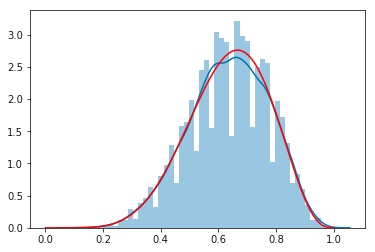

In [17]:
sns.distplot(samples)
plt.plot(p_grid, posterior*1e2, color='red')

(array([ 0.000375,  0.0045  ,  0.02625 ,  0.093875,  0.      ,  0.214625,
         0.33225 ,  0.327125,  0.200375,  0.050625]),
 array([ 1. ,  1.8,  2.6,  3.4,  4.2,  5. ,  5.8,  6.6,  7.4,  8.2,  9. ]),
 <a list of 10 Patch objects>)

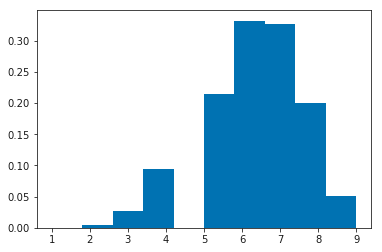

In [18]:
plt.hist(np.random.binomial(9, 0.7, 10000), normed=True)

It seems that if we were to toss a coin with a bias of 0.7 9 times each and count the number of heads and repeat this 10000 times, about 33% of the experiments result in 6 and 33% of the experiments result in 7 successes.

However 0.7 is just one of the _many beliefs_. Our beliefs are represented by the posterior. When we do repeated simulations of what the bias is, we our beliefs should _vary_ according to the posterior. This can be accomplished by repeated sampling of posterior. And running the experiment with that bias.

(array([ 0.003     ,  0.01388889,  0.036     ,  0.08288889,  0.14366667,
         0.19633333,  0.21988889,  0.20755556,  0.14555556,  0.06233333]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

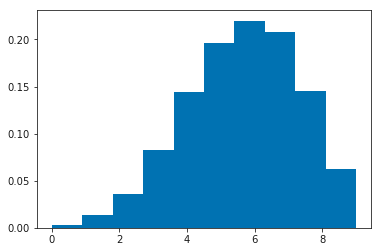

In [19]:
# FIXME: figure out broadcasting
plt.hist(np.random.binomial(9, p=samples), normed=True)